## Movies Reviews Text Based Analysis & Classification Project
ADS509 - Team 3 - Final Group Project<p>
Jacqueline Vo, Connie Chow<p>
October 23, 2023

### Load the Movie Reviews Data

In [101]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import emoji
from string import punctuation
from collections import Counter
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pyLDAvis.sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.metrics import plot_confusion_matrix
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
#from nltk.corpus import stopwords

In [102]:
spacy.cli.download('en_core_web_sm')
nlp = spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [89]:
# Define the URL
url = "https://raw.githubusercontent.com/jvo024/ads509-movie-scrape/main/datasets/all_tmbd_rt_data.csv"

# Read data from the URL into a DataFrame
df = pd.read_csv(url)
df_copy = pd.read_csv(url)

# Display the first few rows of the DataFrame (optional)
df.head()

,movie_title,review_rating,review_content,sentiment
0,Blue Beetle,7.0,MORE SPOILER-FREE MINI-REVIEWS @ https://www.m...,good
1,Blue Beetle,6.0,"Maybe this should just have been called the ""B...",good
2,Blue Beetle,7.0,Blue beetle is very awesome!! WoW!👏🏻👏🏻👍🏻👍🏻,good
3,Blue Beetle,6.0,The Good: Light-hearted and family centric. Lo...,good
4,Meg 2: The Trench,5.0,"Now the ""Meg"" (2018) itself could never be cal...",good


### Text Data Preprocessing

In [90]:
def descriptive_stats(tokens, top_tokens = 10, verbose=True) :

    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = sum(len(token) for token in tokens)
    token_counter = Counter(tokens)
    most_common_tokens = token_counter.most_common(top_tokens)

    if verbose:
        print(f"Number of tokens: {num_tokens}")
        print(f"Number of unique tokens: {num_unique_tokens}")
        print(f"Number of characters: {num_characters}")
        print(f"Lexical diversity: {lexical_diversity:.3f}")
        # 5 most common tokens
        print(f"Most common tokens (Top {top_tokens}):")
        for token, count in most_common_tokens:
            print(f" - {token}: {count}")

    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])


# Use regular expression to match the URL link string and then remove it from the string
def remove_hyperlink(text):
    hyperlink_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    cleaned_text = re.sub(hyperlink_pattern, '', text)
    return cleaned_text

def remove_stop(tokens) :
    removed_tokens = [token for token in tokens if token.lower() not in sw and token != 'nan']
    return(removed_tokens)

def remove_punctuation(text, punct_set=punctuation) :
    if text == 'nan':
        return ''  # Remove 'nan'
    return "".join([ch for ch in text if ch not in punct_set])

def tokenize(text):
    return word_tokenize(text)

def prepare(text, pipeline) :
    tokens = str(text)
    for transform in pipeline :
        tokens = transform(tokens)
    return tokens

punctuation = set(punctuation)
sw = stopwords.words("english")
whitespace_pattern = re.compile(r"\s+")
all_language_emojis = set()

for country in emoji.EMOJI_DATA :
    for em in emoji.EMOJI_DATA[country] :
        all_language_emojis.add(em)

In [91]:
pipeline = [remove_hyperlink, str.lower, remove_punctuation, tokenize, remove_stop]

df["tokens"] = df["review_content"].apply(prepare, pipeline=pipeline)
df["num_tokens"] = df["tokens"].map(len)
df.head()
df_reviews = df

In [92]:
# preprocess the text but do not tokenize, assign to a different df
def remove_hyperlink2(text):
    hyperlink_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    cleaned_text = re.sub(hyperlink_pattern, '', text)
    return cleaned_text

def remove_stop2(text):
    tokens = word_tokenize(text)
    cleaned_tokens = [token for token in tokens if token.lower() not in sw and token != 'nan']
    cleaned_text = " ".join(cleaned_tokens)
    return cleaned_text

def remove_punctuation2(text):
    if text == 'nan':
        return ''  # Remove 'nan'
    return "".join([ch for ch in text if ch not in punctuation])

#print(df_copy['review_content'].head(5))
df_copy['review_content'] = df_copy['review_content'].apply(remove_hyperlink2)
df_copy['review_content'] = df_copy['review_content'].apply(remove_punctuation2)
df_copy['review_content'] = df_copy['review_content'].apply(remove_stop2)
print(df_copy['review_content'].head(5))

0    SPOILERFREE MINIREVIEWS Blue Beetle follows us...
1    Maybe called Blue Bottle annoying blowfly buzz...
2                      Blue beetle awesome WoW👏🏻👏🏻👍🏻👍🏻
3    Good Lighthearted family centric Love story in...
4    Meg 2018 could never called good film great de...
Name: review_content, dtype: object


### Exploratory Data Analysis

#### Descriptive Statistics for Good and Bad Reviews

In [93]:
good_df = df[df['sentiment'] == 'good']
bad_df = df[df['sentiment'] == 'bad']

# combine tokens
good_tokens = good_df["tokens"].sum()
bad_tokens = bad_df["tokens"].sum()

In [94]:
print(f"-- Good Reviews --")
good_stats = descriptive_stats(good_tokens)
print(f"-- Bad Reviews --")
bad_stats = descriptive_stats(bad_tokens)

-- Good Reviews --
Number of tokens: 881997
Number of unique tokens: 50386
Number of characters: 5330186
Lexical diversity: 0.057
Most common tokens (Top 10):
 - film: 10464
 - movie: 8814
 - ’: 7549
 - one: 6790
 - like: 4857
 - story: 4770
 - good: 4330
 - well: 3836
 - really: 3708
 - time: 3544
-- Bad Reviews --
Number of tokens: 133536
Number of unique tokens: 18565
Number of characters: 795180
Lexical diversity: 0.139
Most common tokens (Top 10):
 - movie: 1830
 - film: 1563
 - ’: 1427
 - one: 1046
 - like: 1030
 - even: 745
 - good: 695
 - really: 606
 - story: 565
 - much: 546


#### Token Concentration

In [95]:
from collections import Counter

total_good = good_stats[0]
total_bad = bad_stats[0]

token_counts_good = Counter(good_tokens)
token_counts_bad = Counter(bad_tokens)

good_df = pd.DataFrame(token_counts_good.items(), columns=["token", "good_tokens"])
bad_df = pd.DataFrame(token_counts_bad.items(), columns=["token", "bad_tokens"])

# Calculate the concentration for good_tokens
good_df["good concentration"] = good_df.apply(lambda row: row["good_tokens"] / total_good, axis=1)

# Calculate the concentration for bad_tokens
bad_df["bad concentration"] = bad_df.apply(lambda row: row["bad_tokens"] / total_bad, axis=1)

df = [good_df, bad_df]

group_df = df[0]
for df in df[1:]:
    group_df = pd.merge(group_df, df, on="token", how="inner")

cutoff = 10

def check_cutoff(column):
    return (column['good_tokens'] + column['bad_tokens']) > cutoff

# Apply the custom function to create the new column
group_df['cutoff'] = group_df.apply(check_cutoff, axis=1)

group_df['ratio'] = (group_df["good concentration"])/(group_df["bad concentration"])
sorted_group = group_df.sort_values(by="ratio", ascending=False)
top_group = sorted_group.head(10)
top_group

,token,good_tokens,good concentration,bad_tokens,bad concentration,cutoff,ratio
5547,810,163,0.000185,1,0.000007,True,24.678506
3493,wonderfully,134,0.000152,1,0.000007,True,20.287851
3918,1010,94,0.000107,1,0.000007,True,14.231776
137,denouement,87,0.000099,1,0.000007,True,13.171963
2859,ups,76,0.000086,1,0.000007,True,11.506543
5737,treasure,75,0.000085,1,0.000007,True,11.355141
2836,elevates,73,0.000083,1,0.000007,True,11.052337
4055,mindblowing,72,0.000082,1,0.000007,True,10.900935
8941,woods,71,0.000080,1,0.000007,True,10.749533
7297,2008,70,0.000079,1,0.000007,True,10.598131


#### Word Clouds: Tokens from Bad Reviews Word Cloud & Good Review Word Cloud

In [96]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                   if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")


def count_words(df, column='token', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

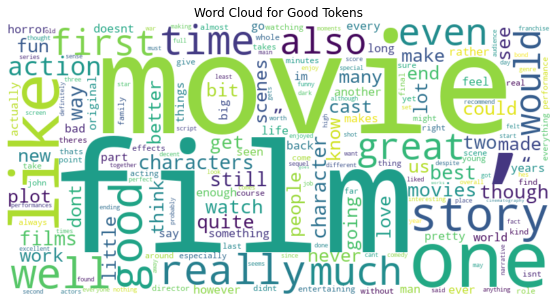

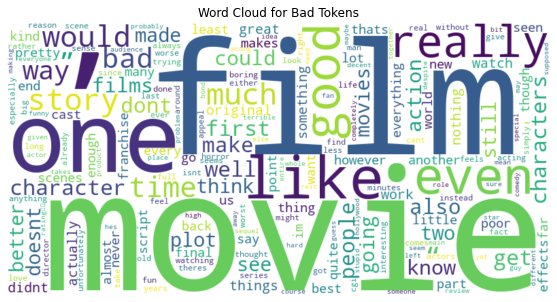

In [97]:
def generate_wordcloud(tokens, title):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tokens)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Create word clouds for good_tokens and bad_tokens
good_word_counts = Counter(good_tokens)
bad_word_counts = Counter(bad_tokens)

generate_wordcloud(good_word_counts, "Word Cloud for Good Tokens")
generate_wordcloud(bad_word_counts, "Word Cloud for Bad Tokens")

#### The most common one word, two word or three word phrases

<AxesSubplot:title={'center':'Bar chart of Bigrams Frequency'}, xlabel='Bigram Words', ylabel='Count'>

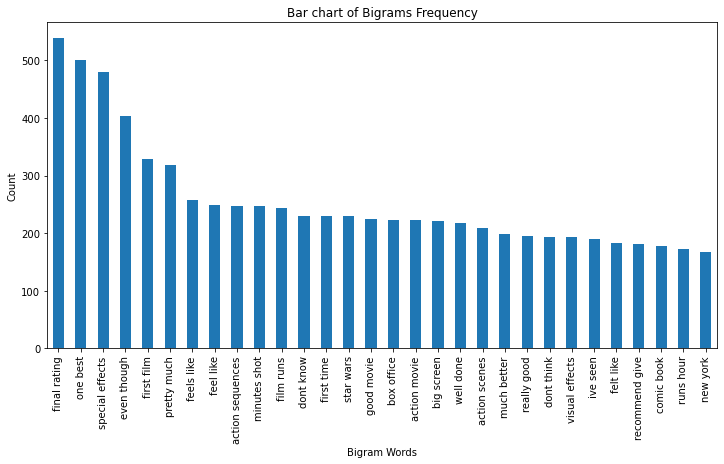

In [98]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words2 = get_top_n_bigram(df_copy['review_content'], 30)
df2 = pd.DataFrame(common_words2, columns=['Text', "Count"])
df2


df2.groupby('Text').sum()['Count'].sort_values(ascending=False).plot(
kind='bar',
figsize=(12,6),
xlabel = "Bigram Words",
ylabel = "Count",
title = "Bar chart of Bigrams Frequency"
)

### Train Test Split Dataset

In [20]:
##################################################################
# Ensure that data is balanced before splitting.  
# There should be an equal number of positive and negative reviews
# before splitting
##################################################################
good_df = df_reviews[df_reviews['sentiment'] == 'good']
bad_df = df_reviews[df_reviews['sentiment'] == 'bad']

# Determine if good or bad reviews df is smaller, use that size as 
# the basis for forming the training set
num_good_rows = len(good_df)
num_bad_rows = len(bad_df)
min_num_rows = min(num_good_rows, num_bad_rows)

# Also assign 1 and 0 binary for good or bad movie reviews to train model
if num_good_rows < num_bad_rows:
    temp_df = good_df.sample(n=min_num_rows, random_state=42)  # Randomly sample from bad_df
    X = pd.concat([temp_df, bad_df])
    X = X.reset_index(drop=True)
    y = X['sentiment']
    y = y.map({"good": 1, "bad": 0})
else:
    temp_df = bad_df.sample(n=min_num_rows, random_state=42)  # Randomly sample from bad_df
    X = pd.concat([good_df, temp_df])
    X = X.reset_index(drop=True)
    y = X['sentiment']
    y = y.map({"good": 1, "bad": 0})

    
# split the data 80/20 ratio
X = X[['review_content']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

"""
from sklearn.preprocessing import LabelEncoder
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Sentiment' column
training_data_output['sentiment'] = label_encoder.fit_transform(training_data_output['sentiment'])
"""

"\nfrom sklearn.preprocessing import LabelEncoder\n# Initialize the LabelEncoder\nlabel_encoder = LabelEncoder()\n\n# Fit and transform the 'Sentiment' column\ntraining_data_output['sentiment'] = label_encoder.fit_transform(training_data_output['sentiment'])\n"

## Modeling & Evaluation

### Naive Bayes Model

In [16]:
##############################################################
# Use cutoff of 10 as the minimum count of words to be considered
# as feature words or words having significance in the corpus
##############################################################
word_cutoff = 10
concatenated_text = ' '.join(df_reviews['review_content'])
tokens = word_tokenize(concatenated_text)
word_dist = nltk.FreqDist(tokens)
feature_words = set()

for word, count in word_dist.items() :
    if count > word_cutoff :
        feature_words.add(word)
        
print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words)} as features in the model.")

With a word cutoff of 10, we have 10838 as features in the model.


In [18]:
##############################################################
# This function takes in the movie review text and list of
# feature words (from above) and marks each word in the review
# as either existing in the feature word list as True or False
# This will be fed as training data to the classifier
##############################################################
def conv_features(text,fw) :
    """Given some text, this returns a dictionary holding the
       feature words.
       
       Args: 
            * text: a piece of text in a continuous string. Assumes
            text has been cleaned and case folded.
            * fw: the *feature words* that we're considering. A word 
            in `text` must be in fw in order to be returned. This 
            prevents us from considering very rarely occurring words.
        
       Returns: 
            A dictionary with the words in `text` that appear in `fw`. 
            Words are only counted once. 
            If `text` were "quick quick brown fox" and `fw` = {'quick','fox','jumps'},
            then this would return a dictionary of 
            {'quick' : True,
             'fox' :    True}
        
    """

    ret_dict = dict()
    
    # Tokenize the text into words
    words = text.split()
   
    # Iterate through the words in the text
    for word in words:
        # Check if the word is in the list of words fw
        if word in fw:
            # If it is in fw, set its value to True in the features dictionary
            ret_dict[word] = True
            
    return {k: v for k, v in ret_dict.items() if v}
    
    return(ret_dict)

In [29]:
##############################################################
# put it into a usable format for the classifier training set
# input format should be:
# a list of tuples, one tuple per possible label and in the
# tuple the first item should be the feature word dictionary
# from above
##############################################################
training_input = []

# for each row in the good_df, get the movie review text and make the dictionary of it
for i,row in good_df.iterrows():
    good_dict = conv_features(row['review_content'], feature_words)
    #print(good_dict)
    t = (good_dict, 1)
    training_input.append(t)


for i,row in bad_df.iterrows():
    bad_dict = conv_features(row['review_content'], feature_words)
    #print(good_dict)
    t = (bad_dict, 0)
    training_input.append(t)
    

In [24]:
featuresets = training_input

In [25]:
# Train the Naive Bayes Classifier
test_size = 500
test_set, train_set = featuresets[:test_size], featuresets[test_size:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.984


In [26]:
# Get the most informative features (tokens)
# On the right hand column, 0 means Bad Review and 1 means Good Review
classifier.show_most_informative_features(25)

Most Informative Features
               product._ = True                0 : 1      =    285.5 : 1.0
                   Avoid = True                0 : 1      =    129.8 : 1.0
                    4/10 = True                0 : 1      =     50.2 : 1.0
                      D+ = True                0 : 1      =     39.8 : 1.0
                      C- = True                0 : 1      =     36.3 : 1.0
                    Woke = True                0 : 1      =     26.0 : 1.0
           Disappointing = True                0 : 1      =     19.0 : 1.0
                 dumbest = True                0 : 1      =     18.5 : 1.0
                    8/10 = True                1 : 0      =     15.6 : 1.0
                    Teen = True                0 : 1      =     15.6 : 1.0
                finished = True                0 : 1      =     15.1 : 1.0
             wonderfully = True                1 : 0      =     13.8 : 1.0
                 unfunny = True                0 : 1      =     13.5 : 1.0

### LinearSVC Model

In [30]:
# Train model on term frequency and inverse term frequency

# Get TFID matrix numbers
freq_vector = CountVectorizer(stop_words = "english")
X_train_freq = freq_vector.fit_transform(X_train['review_content'])
#freq_vector.get_feature_names()
#X_train_freq.shape

tfidf_transf = TfidfTransformer()
X_train_tfidf = tfidf_transf.fit_transform(X_train_freq)
X_train_tfidf.shape

(6941, 42122)

In [31]:
# Fit LinearSVC Model
classifier = LinearSVC()
classifier.fit(X_train_tfidf, y_train)

LinearSVC()

In [38]:
# Model Performance - plot confusion matrix
disp = plot_confusion_matrix(classifier, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None)
disp.ax_.set_title("Confusion Matrix")

C:\Users\Connie\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Connie\Anaconda3\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


ValueError: could not convert string to float: "The movie is not bad directed and the cast does a decent job. Actually, the script is a good adaptation of the book.\r\n\r\nThe problem is that the story of the book is already quite bad and has gone down the sink by now so the whole movie just doesn't work."

#### Random Forest Classifier Model

In [46]:
# Transform the Input Text of Training Data using Trained Tfidf Vectorizer
train_feature_vectors = count_vectorizer.transform(X_train)
#train_feature_vectors = train_feature_vectors.todense()

# Get the name of Features (Feature Set) and create a DataFrame of Input Features
input_training_features = pd.DataFrame(train_feature_vectors, columns = count_vectorizer.get_feature_names())
input_training_features = input_training_features.round(2)

# Display the Document Feature Matrix of Training Data
print("Document Features Matrix of Training Data :")
print("============================================")
#input_training_features = input_training_features.round(2)
input_training_features.head()

# Split the Training Data Outputs / Labels and Create a DataFrame
training_data_output = pd.DataFrame(y_train)

# Output Label Gender of Training Data
print("Output of Training Data:")
print("========================")
training_data_output.head()

from sklearn.preprocessing import LabelEncoder
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Sentiment' column
training_data_output['sentiment'] = label_encoder.fit_transform(y_train)

from sklearn.model_selection import train_test_split

X = input_training_features
y = training_data_output

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

random_forest_classifier = RandomForestClassifier(n_estimators=5, random_state=0)
random_forest = random_forest_classifier.fit(X_train,np.ravel(y_train))

C:\Users\Connie\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


ValueError: Shape of passed values is (46489, 1), indices imply (46489, 46489)

In [28]:
# Transform the Input Text of Training Data using Trained Tfidf Vectorizer
count_vectorizer = CountVectorizer(stop_words = "english")
count_vectorizer = count_vectorizer.fit(X_train['review_content'])
train_feature_vectors = count_vectorizer.transform(df_reviews['review_content'])
train_feature_vectors = train_feature_vectors.todense()

# Get the name of Features (Feature Set) and create a DataFrame of Input Features
input_training_features = pd.DataFrame(train_feature_vectors, columns = count_vectorizer.get_feature_names())
input_training_features = input_training_features.round(2)

training_data_output = pd.DataFrame(df_reviews['sentiment'])
#training_data_output['sentiment'] = label_encoder.fit_transform(training_data_output['sentiment'])

X = input_training_features
y = training_data_output

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

C:\Users\Connie\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


NameError: name 'label_encoder' is not defined

In [ ]:
import numpy as np

random_forest_classifier = RandomForestClassifier(n_estimators=5, random_state=0)
random_forest = random_forest_classifier.fit(X_train,np.ravel(y_train))

print("Parameters and their values:")
print("============================")
print(random_forest)

In [ ]:
predictions = text_clf.predict(X_test)

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, predictions))
print(metrics.classification_report(y_test, predictions))
print(metrics.accuracy_score(y_test, predictions))

## Topic Modeling - LSA, LDA, NMT

### Fitting a Non-Negative Matrix Factorization Model

In [99]:
# Helper method to display topics
def display_topics(model, features, no_top_words=15):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [103]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df_reviews['review_content'])
count_text_vectors.shape

tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df_reviews['review_content'])
tfidf_text_vectors.shape

nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())

C:\Users\Connie\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  % sorted(inconsistent)
C:\Users\Connie\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,



Topic 00
  film (0.83)
  story (0.30)
  like (0.30)
  time (0.24)
  films (0.23)
  characters (0.19)
  character (0.19)
  way (0.18)
  great (0.17)
  good (0.17)
  best (0.17)
  action (0.16)
  new (0.16)
  little (0.15)
  horror (0.15)

Topic 01
  movie (4.51)
  good (1.36)
  watch (0.98)
  like (0.78)
  movies (0.77)
  action (0.74)
  great (0.66)
  bad (0.60)
  story (0.49)
  lot (0.49)
  funny (0.49)
  pretty (0.44)
  best (0.37)
  fun (0.36)
  actually (0.35)

Topic 02
  _final (4.85)
  rating (4.21)
  recommend (2.15)
  appeal (1.91)
  liked (1.80)
  personally (1.58)
  appealed (1.19)
  strongly (1.13)
  didn (1.11)
  finished (1.09)
  product (1.05)
  lot (0.99)
  poor (0.87)
  things (0.81)
  work (0.81)

Topic 03
  em (5.26)
  good (0.83)
  cast (0.62)
  ve (0.56)
  film (0.49)
  enjoyed (0.48)
  entertaining (0.38)
  isn (0.38)
  watch (0.37)
  didn (0.37)
  href (0.37)
  solid (0.37)
  role (0.36)
  great (0.34)
  fun (0.34)

Topic 04
  review (1.76)
  com (1.26)
  https (

In [ ]:
# comparison to corpus

### Fitting an LSA Model

In [104]:
count_para_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(df_reviews['review_content'])
count_para_vectors.shape

lda_para_model = LatentDirichletAllocation(n_components = 5, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

display_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())

C:\Users\Connie\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  % sorted(inconsistent)



Topic 00
  film (0.87)
  movie (0.76)
  like (0.64)
  minutes (0.48)
  grade (0.41)
  shot (0.39)
  runs (0.39)
  new (0.34)
  story (0.30)
  horror (0.30)
  hour (0.27)
  war (0.25)
  time (0.24)
  action (0.23)
  great (0.23)

Topic 01
  film (0.85)
  em (0.72)
  story (0.56)
  good (0.44)
  time (0.42)
  bit (0.42)
  little (0.42)
  great (0.41)
  action (0.36)
  cast (0.36)
  10 (0.35)
  fun (0.32)
  way (0.26)
  pretty (0.25)
  plot (0.24)

Topic 02
  movie (2.96)
  like (1.58)
  film (1.40)
  good (1.25)
  time (0.76)
  watch (0.71)
  story (0.71)
  bad (0.58)
  great (0.58)
  movies (0.57)
  don (0.55)
  lot (0.49)
  think (0.48)
  didn (0.47)
  better (0.44)

Topic 03
  movie (1.86)
  film (1.37)
  story (1.02)
  action (0.86)
  characters (0.58)
  character (0.51)
  time (0.51)
  like (0.47)
  best (0.43)
  review (0.42)
  horror (0.38)
  good (0.36)
  com (0.34)
  movies (0.32)
  great (0.31)

Topic 04
  film (2.51)
  story (0.46)
  bond (0.44)
  like (0.44)
  good (0.43)
  

### Fitting an LDA Model

In [105]:
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_
display_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())

lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

pyLDAvis.display(lda_display)


Topic 00
  film (0.87)
  movie (0.76)
  like (0.64)
  minutes (0.48)
  grade (0.41)
  shot (0.39)
  runs (0.39)
  new (0.34)
  story (0.30)
  horror (0.30)
  hour (0.27)
  war (0.25)
  time (0.24)
  action (0.23)
  great (0.23)

Topic 01
  film (0.85)
  em (0.72)
  story (0.56)
  good (0.44)
  time (0.42)
  bit (0.42)
  little (0.42)
  great (0.41)
  action (0.36)
  cast (0.36)
  10 (0.35)
  fun (0.32)
  way (0.26)
  pretty (0.25)
  plot (0.24)

Topic 02
  movie (2.96)
  like (1.58)
  film (1.40)
  good (1.25)
  time (0.76)
  watch (0.71)
  story (0.71)
  bad (0.58)
  great (0.58)
  movies (0.57)
  don (0.55)
  lot (0.49)
  think (0.48)
  didn (0.47)
  better (0.44)

Topic 03
  movie (1.86)
  film (1.37)
  story (1.02)
  action (0.86)
  characters (0.58)
  character (0.51)
  time (0.51)
  like (0.47)
  best (0.43)
  review (0.42)
  horror (0.38)
  good (0.36)
  com (0.34)
  movies (0.32)
  great (0.31)

Topic 04
  film (2.51)
  story (0.46)
  bond (0.44)
  like (0.44)
  good (0.43)
  

AttributeError: module 'pyLDAvis' has no attribute 'lda_model'